In [1]:
import tensorflow as tf
import numpy as np
import os

In [2]:
def load_data(path):
    x = None
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'rb') as f:
            tmp = tf.cast([np.load(f)], dtype=tf.float64)
            if x is None:
                x = tf.linalg.matmul(tmp, tmp, transpose_b=True)
            else:
                x = tf.concat([x, tf.linalg.matmul(tmp, tmp, transpose_b=True)], axis=0)
    return x

In [3]:
steps = 200
# alphas, betas, gammas = [1.0, 0.1], [1000.0, 2000.0, 100.0], [0.01, 0.1]
alphas, betas, gammas = [0.1], [1000.0], [0.01]

In [4]:
def fusion(x, k, alpha, beta, gamma):
    f = None
    n = x.shape[1]
    t = x.shape[0]
    reg = gamma / (4.0 * beta)
    wv, wv_u = tf.cast([1.0 / t for _ in range(t)], dtype=tf.float64), None
    i_alpha = tf.math.multiply(tf.eye(n, dtype=tf.float64), alpha)
    i_beta = tf.math.multiply(tf.eye(n, dtype=tf.float64), beta)
    s = tf.eye(n, dtype=tf.float64)
    for step in range(steps):
        s = tf.where(s > 0, s, tf.zeros(s.shape, dtype=tf.float64))
        s = tf.math.divide(tf.math.add(s, tf.transpose(s)), 2.0)
        z_sum = tf.zeros(s.shape, dtype=tf.float64)
        for i in range(t):
            z = tf.linalg.solve(
                tf.math.add(tf.math.add(x[i], i_alpha), tf.math.multiply(i_beta, wv[i])),
                tf.math.add(tf.math.multiply(s, tf.math.multiply(wv[i], beta)), x[i]))
            z = tf.where(z > 0, z, tf.zeros(z.shape, dtype=tf.float64))
            z = tf.math.divide(tf.math.add(z, tf.transpose(z)), 2.0)
            w = tf.math.divide(0.5, tf.norm(tf.math.subtract(z, s)))
            wv_u = tf.reshape(w, [1]) if i == 0 else tf.concat([wv_u, [w]], axis=0)
            z = tf.math.multiply(z, w)
            z_sum = tf.math.add(z_sum, z)

        l = tf.math.subtract(tf.linalg.diag(tf.math.reduce_sum(s, 0)), s)
        (_, f) = tf.linalg.eigh(l)
        f = tf.slice(f, [0, 0], [f.shape[0], k])
        p = tf.norm(tf.math.subtract(f[0][:], f), axis=1, keepdims=True)
        for i in range(1, n):
             p = tf.concat([p, tf.norm(tf.math.subtract(f[0][:], f), axis=1, keepdims=True)], 1)
        p = tf.math.multiply(tf.math.square(p), reg)
        wv = wv_u
        s_old = s
        s = tf.math.divide((tf.math.subtract(z_sum, p)), tf.math.reduce_sum(wv, 0))
        if step > 5 and tf.math.less(tf.math.divide(tf.norm(tf.math.subtract(s, s_old)), tf.norm(s_old)), 1.e-4):
            print('Criterion found after', step, 'steps')
            return f
    return f

In [5]:
from sklearn.cluster import KMeans

def run_k_means(k, f):
        k_means = KMeans(n_clusters=k, n_init=12).fit(f)
        clusters = k_means.labels_
        d = {}
        for i in clusters:
            if i in d:
                d[i] += 1
            else:
                d[i] = 1
        histograms[k] = d
        max_k = 0
        for i in d:
            max_k = max(max_k, d[i])
        print('Biggest cluster:', max_k)
        print('k:', k, '\n', 'Clusters:', d)
        return clusters

In [6]:
def run_experiments(ks, views):
    d = {}
    x = load_data(views)
    print(x.shape)
    for k in ks:
        d[k] = {}
        for alpha in alphas:
            d[k][alpha] = {}
            for beta in betas:
                d[k][alpha][beta] = {}
                for gamma in gammas:
                    print('Run with parameters', alpha, beta, gamma)
                    d[k][alpha][beta][gamma] = run_k_means(k, fusion(x, k, alpha, beta, gamma).numpy())
    return d

In [7]:
def save_np(name, matrix):
    with open(name + ".npy", 'wb') as f:
        np.save(f, matrix)

def save_results(results, c_id):
    for k in results:
        for alpha in results[k]:
            for beta in results[k][alpha]:
                for gamma in results[k][alpha][beta]:
                    tmp = 'clusters/'+c_id+'_'+ str(k)+'_'+str(alpha)+'_'+str(beta)+'_'+str(gamma)
                    save_np(tmp, results[k][alpha][beta][gamma])

In [8]:
histograms = {}
save_results(run_experiments([30, 50, 70, 100, 200, 300], 'views/profiles/'), 'profiles2')

(2, 391, 391)
Run with parameters 0.1 1000.0 0.01
Criterion found after 6 steps
Biggest cluster: 106
k: 30 
 Clusters: {17: 13, 4: 12, 24: 3, 9: 7, 13: 2, 29: 7, 3: 5, 6: 8, 21: 9, 11: 6, 5: 3, 8: 14, 22: 7, 0: 17, 26: 4, 2: 28, 1: 11, 23: 42, 14: 106, 16: 3, 18: 38, 10: 2, 7: 6, 25: 13, 20: 9, 19: 2, 12: 3, 28: 2, 15: 7, 27: 2}
Run with parameters 0.1 1000.0 0.01
Criterion found after 6 steps
Biggest cluster: 70
k: 50 
 Clusters: {19: 4, 42: 15, 7: 8, 27: 10, 15: 2, 16: 7, 29: 3, 9: 8, 39: 7, 31: 6, 26: 3, 2: 7, 13: 12, 38: 8, 4: 6, 23: 4, 49: 5, 44: 3, 12: 7, 24: 22, 3: 11, 28: 70, 8: 3, 41: 5, 47: 4, 34: 2, 11: 2, 10: 27, 20: 3, 46: 4, 37: 2, 5: 14, 6: 16, 40: 6, 33: 2, 21: 2, 18: 5, 25: 3, 1: 2, 14: 14, 45: 2, 36: 2, 0: 11, 17: 2, 30: 22, 48: 2, 43: 1, 32: 1, 22: 2, 35: 2}
Run with parameters 0.1 1000.0 0.01
Criterion found after 6 steps
Biggest cluster: 51
k: 70 
 Clusters: {53: 4, 38: 14, 43: 3, 60: 4, 65: 2, 45: 3, 21: 3, 28: 8, 26: 9, 56: 6, 24: 3, 62: 3, 25: 4, 29: 2, 49: 3, 3

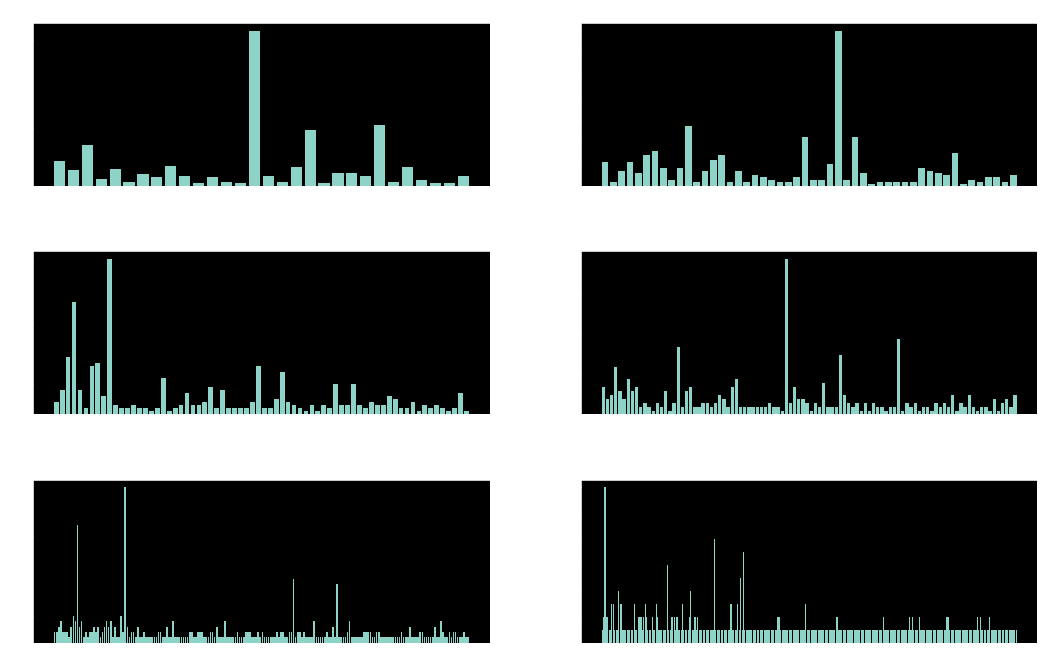

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 24))
plt.style.use('dark_background')

def plot_histograms():
    plt.subplots_adjust(hspace=0.4)
    cnt = 1
    for i in histograms:
        plt.subplot(len(histograms), 2, cnt)
        cnt += 1
        d = histograms[i]
        plt.bar(d.keys(), d.values())
        plt.title('k: ' + str(i))

plot_histograms()